In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from scipy import signal



In [2]:
raw = mne.io.read_raw_edf('SC4001E0-PSG.edf', preload=True)
raw.set_channel_types({'EOG horizontal': 'eog'})
raw.set_channel_types({'EMG submental': 'emg'})
raw.drop_channels(['Resp oro-nasal', 'Temp rectal', 'Event marker'])
print(raw.info['chs'])

Extracting EDF parameters from c:\Users\hsuan\OneDrive\Desktop\Python\Eureka\BCI\ICA\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
[{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'EEG Fpz-Cz', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 2, 'scanno': 2, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'EEG Pz-Oz', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 3, 'scanno': 3, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'EOG horizontal', 'unit': 107 (FIFF_UN

In [3]:
montage = mne.channels.make_standard_montage('standard_1005')
# Get the position of the 'Fz' channel
channel_pos_fzcz = montage.get_positions()['ch_pos']['Fz']
channel_pos_pzoz = montage.get_positions()['ch_pos']['Pz']
# Create a custom montage
montage = mne.channels.make_dig_montage({ 'EEG Fpz-Cz': channel_pos_fzcz, 'EEG Pz-Oz': channel_pos_pzoz }, coord_frame='head')
raw.set_channel_types({ 'EEG Fpz-Cz': 'eeg', 'EEG Pz-Oz': 'eeg' })
raw.set_montage(montage)
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, EMG submental
 chs: 2 EEG, 1 EOG, 1 EMG
 custom_ref_applied: False
 dig: 5 items (3 Cardinal, 2 EEG)
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 4
 projs: []
 sfreq: 100.0 Hz
>

# RAW

In [4]:
from mne.preprocessing import ICA
raw_ica = ICA(n_components=2, random_state=0)
raw_ica.fit(raw)

Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 1.9s.


Method,fastica
Fit,4 iterations on raw data (7950000 samples)
ICA components,2
Available PCA components,2
Channel types,eeg
ICA components marked for exclusion,—


In [7]:
raw_ica.fit(raw)
raw_ica_labels = raw_ica.labels_
raw_ica_components = raw_ica.get_components()

print(len(raw_ica_components))
print(len(raw_ica_labels))

Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 1.8s.
2
0


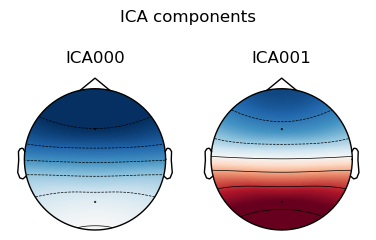

[<MNEFigure size 390x260.5 with 2 Axes>]

In [ ]:
raw_ica.plot_components()

In [8]:
# find components that correlate with EOG activity
eog_indices, eog_scores = raw_ica.find_bads_eog(raw)
raw_ica.labels_["eog"] = eog_indices

# now let's see what's in .labels_
print(raw_ica.labels_)

Using EOG channel: EOG horizontal
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1000 samples (10.000 s)



[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


{'eog/0/EOG horizontal': [], 'eog': []}


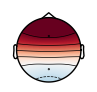

(<matplotlib.image.AxesImage at 0x1db12189750>,
 <matplotlib.contour.QuadContourSet at 0x1db11e05c60>)

In [9]:
from mne.viz import plot_topomap

component_idx = 0 
mixing_matrix = raw_ica.mixing_matrix_ 
component_topo_data = mixing_matrix[:, component_idx]
plot_topomap(component_topo_data, raw_ica.info)

# Filtered

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.90 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 49.95 Hz)
- Filter length: 3301 samples (33.010 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting ICA to data using 2 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


Selecting by number: 2 components
Fitting ICA took 1.8s.


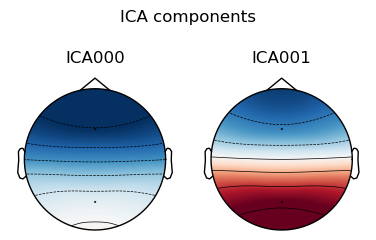

[<MNEFigure size 390x260.5 with 2 Axes>]

In [10]:
from scipy.fft import fft, fftfreq
sampling_rate = 1000  # Sampling rate in Hz
low_freq = 1  # 低频截止频率
high_freq = 49.9  # 高频截止频率
filter_order = 4  # 滤波器阶数

raw_filtered = raw.copy()
raw_filtered.load_data()
raw_filtered.filter(low_freq, high_freq, fir_design='firwin', filter_length='auto', l_trans_bandwidth='auto', h_trans_bandwidth='auto', method='fir', phase='zero', fir_window='hamming', verbose=True)

filtered_ica = ICA(n_components=2, random_state=0)
filtered_ica.fit(raw_filtered)

filtered_ica_labels = filtered_ica.labels_
filtered_ica_components = filtered_ica.get_components()
filtered_ica.plot_components()


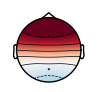

(<matplotlib.image.AxesImage at 0x1db12c67c40>,
 <matplotlib.contour.QuadContourSet at 0x1db12c67e50>)

In [13]:

mixing_matrix = filtered_ica.mixing_matrix_ 
component_topo_data = mixing_matrix[:, component_idx]
plot_topomap(component_topo_data, filtered_ica.info)

# ASR

In [11]:
from asrpy import ASR

sfreq = raw.info["sfreq"]
asr = ASR(sfreq=sfreq, cutoff=5)
asr.fit(raw_filtered.crop(tmax=100))
asr_filtered_data = asr.transform(raw)


asr_ica = ICA(n_components=2, random_state=0)
asr_ica.fit(asr_filtered_data)
asr_ica_components = asr_ica.get_components()
asr_ica_labels = asr_ica.labels_


Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 1.7s.


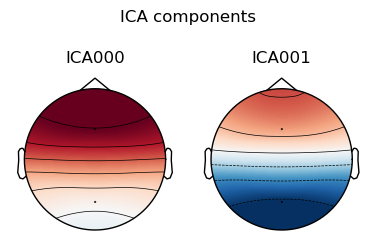

[<MNEFigure size 390x260.5 with 2 Axes>]

In [12]:
asr_ica.plot_components()